# KNN regression

In [23]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from statsmodels.tools.eval_measures import stde


## Read the etl info results

In [24]:
df_info = pd.read_csv('../dataset_clean/options_csv_v1_etl.csv')
df_info

,remove_time_features,generic_features,remove_atypical_values,feature_combination,remove_feature_selection,remove_invalid_correlated_features
0,False,False,False,False,Lasso,False


## Read the dataset

In [25]:
df = pd.read_csv('../dataset_clean/PlatteRiverWeir_features_v1_clean.csv')
df

,SensorTime,CaptureTime,Stage,Discharge,grayMean,graySigma,hMean,hSigma,grayMean0,hMean0,entropyMean1,entropySigma1,hMean1,WwRawLineMean,WwRawLineSigma,WwCurveLineMean,WwCurveLineSigma
0,2012-06-09 13:15:00,2012-06-09T13:09:07,2.99,916.0,97.405096,39.623303,105.368375,41.572939,97.084576,106.047217,0.092532,0.632319,169.963345,0.000000,0.000000,0.000000,0.000000
1,2012-06-09 13:15:00,2012-06-09T13:10:29,2.99,916.0,104.066757,40.179745,112.399458,41.795584,105.668610,114.886049,0.090279,0.620077,175.220945,0.000000,0.000000,0.000000,0.000000
2,2012-06-09 13:45:00,2012-06-09T13:44:01,2.96,873.0,105.636831,40.533218,114.021526,42.145582,106.786307,116.053131,0.090561,0.620853,179.554842,0.000000,0.000000,0.000000,0.000000
3,2012-06-09 14:45:00,2012-06-09T14:44:30,2.94,846.0,104.418949,41.752678,112.612830,43.575351,107.674299,117.005027,0.095616,0.651642,180.921521,0.000000,0.000000,0.000000,0.000000
4,2012-06-09 15:45:00,2012-06-09T15:44:59,2.94,846.0,106.763541,44.442097,114.839424,46.302008,114.858589,124.519271,0.101601,0.688024,183.131779,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42054,2019-10-11 09:00:00,2019-10-11T08:59:53,2.54,434.0,82.872720,57.702652,87.260572,61.485334,43.737485,46.616662,0.120668,0.824195,126.181417,38385.370066,15952.029728,37550.894823,16444.401209
42055,2019-10-11 10:00:00,2019-10-11T09:59:52,2.54,434.0,89.028383,55.840861,94.175906,59.006132,46.268458,49.716207,0.113951,0.783437,131.754200,40162.989292,15467.708856,39397.339095,16009.008049
42056,2019-10-11 11:00:00,2019-10-11T10:59:52,2.54,434.0,94.722097,54.355753,100.534577,56.921028,49.841325,53.984763,0.110346,0.766074,138.014068,42095.946590,16770.357949,41350.006568,17489.374617
42057,2019-10-11 12:00:00,2019-10-11T11:59:53,2.54,434.0,96.693270,52.787629,102.891159,55.083532,53.912185,58.857575,0.112571,0.777376,146.470365,45345.490954,17498.432849,44553.920296,18268.294896


In [26]:
df['SensorTime'] = pd.to_datetime(df['SensorTime'])
df['Year'] = df['SensorTime'].dt.year

In [27]:
df.dtypes

SensorTime          datetime64[ns]
CaptureTime                 object
Stage                      float64
Discharge                  float64
grayMean                   float64
graySigma                  float64
hMean                      float64
hSigma                     float64
grayMean0                  float64
hMean0                     float64
entropyMean1               float64
entropySigma1              float64
hMean1                     float64
WwRawLineMean              float64
WwRawLineSigma             float64
WwCurveLineMean            float64
WwCurveLineSigma           float64
Year                         int64
dtype: object

In [28]:
df = df[(df.Stage > 0) & (df.Discharge > 0)]

In [29]:
df.isna().sum()

SensorTime          0
CaptureTime         0
Stage               0
Discharge           0
grayMean            0
graySigma           0
hMean               0
hSigma              0
grayMean0           0
hMean0              0
entropyMean1        0
entropySigma1       0
hMean1              0
WwRawLineMean       0
WwRawLineSigma      0
WwCurveLineMean     0
WwCurveLineSigma    0
Year                0
dtype: int64

## Divide dataset to X and Y

In [30]:
np.random.seed(0)

df_train = df[(df.Year >= 2012) & (df.Year <= 2017)]
df_train = df_train.iloc[np.random.permutation(len(df_train))]

df_test = df[(df.Year >= 2018) & (df.Year <= 2019)]

In [31]:
df_train = df_train.drop(columns=["Year", "SensorTime", "CaptureTime"])
df_test = df_test.drop(columns=["Year", "SensorTime", "CaptureTime"])

In [32]:
#y_train = df_train[["Stage", "Discharge"]]
y_train = df_train["Stage"]
X_train = df_train.drop(columns=["Stage", "Discharge"])
y_test = df_test["Stage"]
X_test = df_test.drop(columns=["Stage", "Discharge"])

In [33]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

## Train model

In [34]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsRegressor())
])

#param_grid = {'clf__hidden_layer_sizes': [(10), (10, 20), (10, 5, 15), (20, 30, 10, 15)], 'clf__alpha': np.arange(1e-3, 1, 0.001), 'clf__learning_rate_init': np.arange(1e-3, 0.1, 0.001), 'clf__activation': ['tanh', 'relu']}

param_grid = {'clf__n_neighbors': [5, 10, 15, 20, 40, 60], 'clf__leaf_size': [10, 15, 20, 30, 45, 50, 60]}

clf = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=30, n_jobs=10, verbose=3, scoring="neg_mean_squared_error")

In [35]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 2/5] END clf__leaf_size=50, clf__n_neighbors=5;, score=-0.177 total time=   0.3s
[CV 1/5] END clf__leaf_size=50, clf__n_neighbors=5;, score=-0.162 total time=   0.3s
[CV 3/5] END clf__leaf_size=50, clf__n_neighbors=5;, score=-0.171 total time=   0.3s
[CV 5/5] END clf__leaf_size=50, clf__n_neighbors=10;, score=-0.169 total time=   0.3s
[CV 4/5] END clf__leaf_size=50, clf__n_neighbors=5;, score=-0.180 total time=   0.3s
[CV 5/5] END clf__leaf_size=50, clf__n_neighbors=5;, score=-0.164 total time=   0.3s
[CV 2/5] END clf__leaf_size=50, clf__n_neighbors=10;, score=-0.179 total time=   0.4s
[CV 1/5] END clf__leaf_size=50, clf__n_neighbors=10;, score=-0.174 total time=   0.4s
[CV 4/5] END clf__leaf_size=50, clf__n_neighbors=10;, score=-0.178 total time=   0.4s
[CV 3/5] END clf__leaf_size=50, clf__n_neighbors=10;, score=-0.173 total time=   0.4s
[CV 1/5] END clf__leaf_size=30, clf__n_neighbors=5;, score=-0.162 total time=   0.3

RandomizedSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('clf', KNeighborsRegressor())]),
                   n_iter=30, n_jobs=10,
                   param_distributions={'clf__leaf_size': [10, 15, 20, 30, 45,
                                                           50, 60],
                                        'clf__n_neighbors': [5, 10, 15, 20, 40,
                                                             60]},
                   scoring='neg_mean_squared_error', verbose=3)

In [36]:
clf.best_score_

-0.1705751897108685

In [37]:
clf.best_params_

{'clf__n_neighbors': 5, 'clf__leaf_size': 50}

## Test model

In [38]:
clf.score(X_test, y_test)


-0.19180460124145515

In [39]:
y_pred = clf.predict(X_test)

In [40]:
print("R^2: ", r2_score(y_test, y_pred))
print("mse: ", mean_squared_error(y_test, y_pred))
print("rmse: ", mean_squared_error(y_test, y_pred, squared=False))
print("mae: ", mean_absolute_error(y_test, y_pred))
print("mape: ", mean_absolute_percentage_error(y_test, y_pred))
print("Error estandar: ", stde(y_test.squeeze(),
      y_pred.squeeze(), ddof=len(X_train.columns) + 1))


R^2:  0.5088720405117706
mse:  0.19180460124145515
rmse:  0.43795502193884606
mae:  0.27828899190696943
mape:  0.1032312787570824
Error estandar:  0.41655566262825766


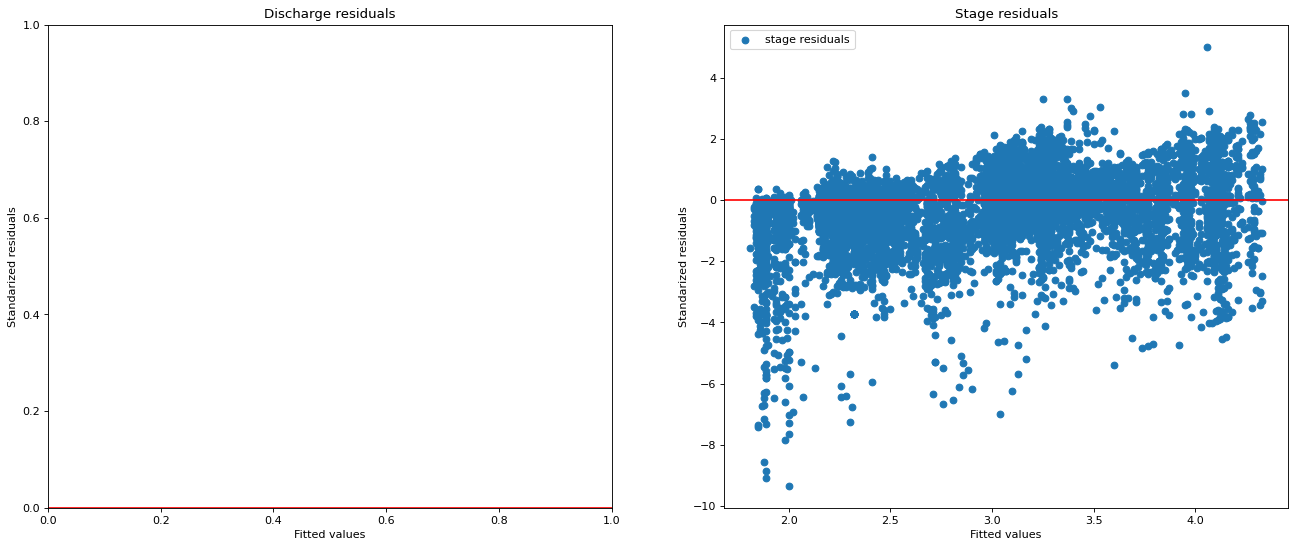

In [41]:
residuals = y_test - y_pred
residuals_std = residuals/residuals.std()

y_real_stage = y_test
residual_stage = residuals

#y_real_discharge = np.array([i[-1] for i in y_test])
#residual_discharge = np.array([i[-1] for i in residuals])


figure, ax = plt.subplots(ncols=2, figsize=(20, 8), dpi=80)

ax[1].scatter(y_real_stage, residual_stage / residual_stage.std(), label="stage residuals")
#ax[0].scatter(y_real_discharge, residual_discharge / residual_discharge.std(), label="discharge residuals")
ax[1].axhline(y=0.0, color='r', linestyle='-')
ax[0].axhline(y=0.0, color='r', linestyle='-')

ax[1].set_title("Stage residuals")
ax[0].set_title("Discharge residuals")

ax[1].set_xlabel("Fitted values")
ax[0].set_xlabel("Fitted values")
ax[1].set_ylabel("Standarized residuals")
ax[0].set_ylabel("Standarized residuals")

plt.legend()
plt.show()

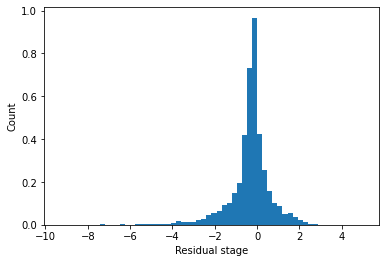

In [42]:
plt.hist(residual_stage / residual_stage.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual stage');
plt.show()

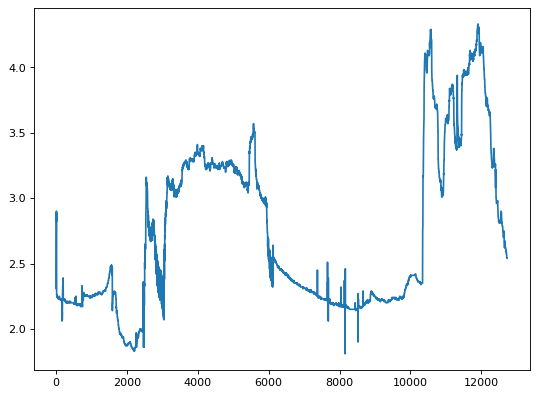

In [43]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(np.arange(len(y_test)), y_test, label="Stage real")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


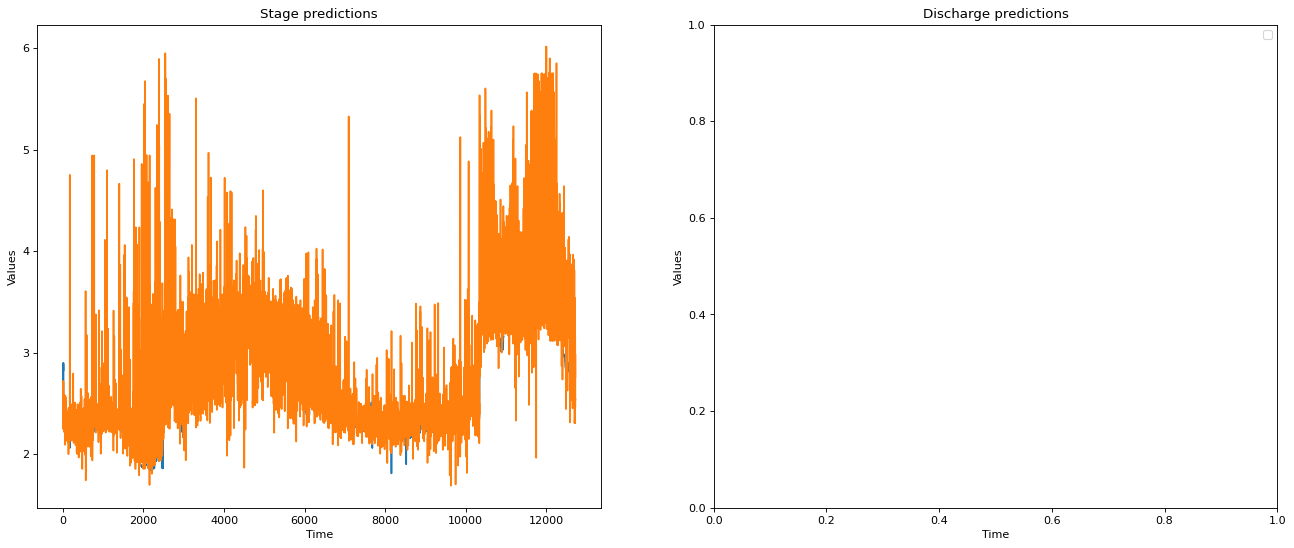

In [44]:
figure, ax = plt.subplots(ncols=2, figsize=(20, 8), dpi=80)

ax[0].plot(np.arange(len(y_test)), y_test, label="Stage real")
ax[0].plot(np.arange(len(y_test)), y_pred, label="Stage pred")

ax[0].set_title("Stage predictions")
ax[1].set_title("Discharge predictions")

ax[1].set_ylabel("Values")
ax[0].set_ylabel("Values")
ax[1].set_xlabel("Time")
ax[0].set_xlabel("Time")

plt.legend()
plt.show()